Code from https://www.kaggle.com/dansbecker/learning-to-use-xgboost

In [1216]:
import os, operator
import pandas as pd
from sklearn.preprocessing import Imputer
import xgboost as xgb
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing, svm, datasets
import sklearn
from sklearn.metrics import roc_curve, auc, recall_score, precision_score,mean_absolute_error,confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import *
from sklearn.model_selection import train_test_split,  KFold, ShuffleSplit
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from IPython.display import Audio, display
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
wat je moet doen is het volgende:
    maak een testset uit alle data (misschien niet eens 25%)
    resample de overgebleven trainset zó, dat je er evenveel 0en als 1en uithaalt.
    train het model op de geresamplede trainset.
    test het model op de initieel gemaakte testset
    
hoe goed presteert het model nu? Doe een paar runs met verschillende splits

### load data from files and scale

In [204]:
files = []
path = "C:\Users\sternheimam\Desktop\my-notebook\user-csvs_predictions"

for filename in os.listdir(path):
    files.append(pd.read_csv(os.path.join(path, filename)))
    
data = pd.concat(files)
#data['Date & Time'] = [(datetime.strptime(d, '%Y-%m-%d %H:%M:%S')-datetime(1970,1,1)).total_seconds() for d in data["Date & Time"]]
data = data.drop('Date & Time',1)
data = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(data))
# is this the right scaler?

In [208]:
# datetime, sentences in this bin, sum of sentences in last month
#0: churn in 12,
#1: churn in 3,
#2: churn in 6,
#(datetime`),
#3: inactivity,
#4: questions,
#5: sentences,
#6: sentiment,
#7: subjectivity,
#8: sentence mean 1 month back,
#9: inactive mean 1 month back,
#10: questions mean 1 month back
#11: sentiment mean 1 month back
#12: subjectivity mean 1 month back
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.0,0.0,0.018534,0.0,0.010050,0.570833,0.380000,0.135135,0.018534,0.0,0.611111,0.400000
1,0.0,0.0,0.0,0.000000,0.0,0.011055,0.501207,0.437915,0.141892,0.009267,0.0,0.544800,0.430482
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.500000,0.000000,0.094595,0.006178,0.0,0.521930,0.286988
3,0.0,0.0,0.0,0.000204,0.0,0.019430,0.494747,0.421135,0.136261,0.004684,0.0,0.507994,0.326066
4,0.0,0.0,0.0,0.000000,0.0,0.010050,0.510387,0.340079,0.136036,0.003747,0.0,0.505590,0.332448


### Extract a test set and training set

#### here: test and training set from original data (unbalanced)

In [600]:
def Set_Xy(data, method = None, col = 1):
    if method == "unbalanced":
        y = data[col].reset_index(drop=True)
        X = data.drop([0,1,2], axis = 1).reset_index(drop=True)

    if method == "balanced":
        # balance the data
        all_1 = data[(data[col]==1)]
        all_0 = data.drop(all_1.index).sample(n=len(all_3))
        balanced = pd.concat([all_1,all_0])

        # extract a test set and training set from the balanced data
        y = balanced[col].reset_index(drop=True)
        X = balanced.drop([0,1,2], axis = 1).reset_index(drop=True)
    return (X,y)


def Split_data(train_index,test_index):
    train_X = X.drop(test_index)
    test_X = X.drop(train_index)
    train_y = y.drop(test_index)
    test_y = y.drop(train_index)
    
    return(train_X,test_X,train_y,test_y)

In [608]:
X, y = Set_Xy(data,"balanced")

ss = ShuffleSplit(n_splits=2, test_size = .25)
for train_index,test_index in ss.split(X):
    train_X,test_X,train_y,test_y = Split_data(train_index,test_index)
    # doe dingen

# Confusion matrix

## etcetera

In [889]:
data_type = "balanced"
X, y = Set_Xy(data,data_type)
train_X,test_X,train_y,test_y = Split_data(train_index,test_index)
feature_names = ["inactivity","questions","sentences","sentiment","subjectivity",
                 "sentence mean","inactive mean","questions mean","sentiment mean","subjectivity mean"]
dtrain = xgb.DMatrix(train_X.as_matrix(),label=train_y.as_matrix(),feature_names=feature_names)
dtest = xgb.DMatrix(test_X.as_matrix(),label=test_y.as_matrix(),feature_names=feature_names)

    classifier = xgb.XGBClassifier(n_estimators=200,learning_rate=0.2,max_depth=8)
    y_score = classifier.fit(train_X, train_y).predict(test_X)

In [1374]:
my_model = clf.best_estimator_
my_model.fit(train_X,train_y, eval_metric="auc")
proba = my_model.predict_proba(test_X)

In [1368]:
import inspect
inspect.getargspec(skplt.metrics.plot_precision_recall)

ArgSpec(args=['y_true', 'y_probas', 'title', 'plot_micro', 'classes_to_plot', 'ax', 'figsize', 'cmap', 'title_fontsize', 'text_fontsize'], varargs=None, keywords=None, defaults=(u'Precision-Recall Curve', True, None, None, None, u'nipy_spectral', u'large', u'medium'))

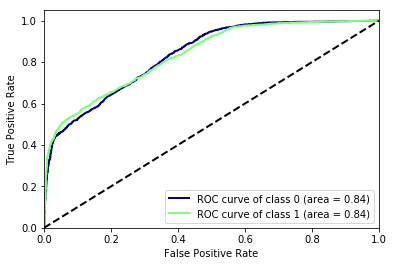

In [1465]:
skplt.metrics.plot_roc([int(y) for y in test_y], list(proba), plot_macro=False, plot_micro=False, title="", cmap="jet")
plt.show()

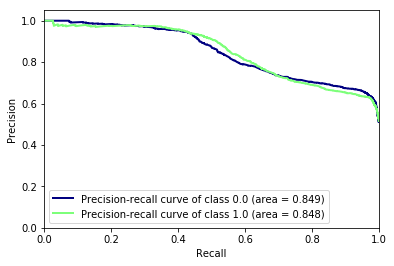

In [1384]:
skplt.metrics.plot_precision_recall(list(test_y), list(proba),plot_micro=False,title="",cmap="jet")
plt.show()

In [1339]:
print my_model

XGBClassifier(base_score=0.496598639456, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=400, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)


In [1336]:
pred = my_model.predict_proba(test_X)

AttributeError: 'Booster' object has no attribute 'predict_proba'

<type 'numpy.ndarray'>


In [1302]:
from sklearn.metrics import roc_auc_score
AUC = roc_auc_score(test_y,pred)
print AUC

0.7000037864017691


xgb.DMatrix is een matrix geoptimaliseerd voor snelheid en efficientie
    de geoutputte matrices noem je vaak dtrain of dtest
xgb.Booster is the model of xgboost. je geeft er 'booster params' aan mee
xgb.train traint een booster (=model) met gegeven parameters
    parameters: params (voor booster!), dtrain, number of boosting iterations , evals (list of pairs matrix-sting): items to be evaluated during training, ..., ..., ..., early-stopping rounds (en dan model.best_...!)
xgb.XGBClassifier is een implementatie van 'xgb.train' voor classificatie.
    params: max_depth, learning_rate/eta, n_estimators, objective, booster, 

In [1114]:
#run when you want to save the results as a baseline for the figure
reference_auc_test = results_dict['validation']['auc']
reference_auc_train = results_dict['train']['auc']
reference_lolo_test = results_dict['validation']['logloss']
reference_lolo_train = results_dict['train']['logloss']

In [ ]:
# eta = 0.1 werkt beter dan 0.05
# depth = 7 werkt beter dan 5
# gecombineerd is nog beter
# rounds verhogen verbetert de score ook, maar alleen op langere runtime-termijn
# early stopping verlagen zorgt dat het algoritme vroeg afbreekt

In [1279]:
def as_df(results = clf.cv_results_):
    rank = results['rank_test_score']
    means = results['mean_test_score']
    stds = results['std_test_score']
    
    df = pd.DataFrame()
    values = defaultdict(list)
    
    for rank, mean, std, params in zip(rank, means, stds, results['params']):
        values['mean'].append(mean)
        values['stdv'].append(std)
        values['rank'].append(rank)
        for p in params:
            values[p].append(params[p])

        for p in values:
            df[p] = values[p]

        df = df.reindex(columns=["learning_rate","max_depth","n_estimators","rank","mean","stdv"])

    return df.sort_values(['rank'])

In [1217]:
def allDone():
    display(Audio("youtube.mp3", autoplay=True)) # "job's done

# Grid search

In [1273]:
k=1
data_type = "balanced"
X, y = Set_Xy(data,data_type)  
ss = ShuffleSplit(n_splits=k, test_size = .25)
with tqdm(total = k) as pbar:
    for train_index,test_index in ss.split(X):
        train_X,test_X,train_y,test_y = Split_data(train_index,test_index)

        parameters = {'objective':['binary:logistic'],
                      'learning_rate': [0.05,0.1,0.2], #so called `eta` value
                      'max_depth': [4,6,8],
                      'silent': [True],
                      'n_estimators': [400] #number of trees, change it to 1000 for better results
                     }        
        clf = GridSearchCV(xgb.XGBClassifier(), #the estimator object
                           parameters, #the parameter grid.
                           cv=StratifiedKFold(train_y,
                                              n_folds=10, 
                                              shuffle=True), 
                           scoring='roc_auc')
        clf.fit(train_X, train_y)
        
        print("Best parameters set found on development set:")
        print
        print(clf.best_params_)
        print
        print("Grid scores on development set:")
        print
        print as_df(clf.cv_results_).head()

        pbar.update(1)
    allDone()

A Jupyter Widget

Best parameters set found on development set:

{'n_estimators': 400, 'objective': 'binary:logistic', 'learning_rate': 0.2, 'max_depth': 8, 'silent': True}

Grid scores on development set:




NameError: name 'print_as_df' is not defined

In [1289]:
for p in clf.cv_results_['mean_test_score']:
    print p


0.7425035757268872
0.8028009435456412
0.8390725144966529
0.7850498526129154
0.8338524825100373
0.8563292072712828
0.820870995181165
0.853269683201033
0.8633077917536808


In [1300]:
clf.best_estimator_

XGBClassifier(base_score=0.496598639456, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=400, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

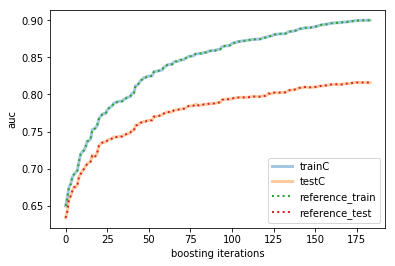

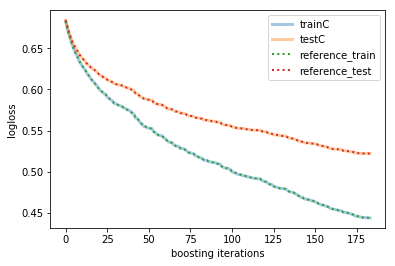

In [1115]:
plt.close()
plt.plot(classifier.evals_result()['validation_0']['auc'],label='trainC',linewidth = 3, alpha = 0.4)
plt.plot(classifier.evals_result()['validation_1']['auc'],label = 'testC',linewidth = 3, alpha = 0.4)
plt.plot(reference_auc_train,label = "reference_train", linestyle = ":",linewidth = 2)
plt.plot(reference_auc_test, label = "reference_test", linestyle = ":",linewidth = 2)
plt.xlabel("boosting iterations")
plt.ylabel("auc")
plt.legend()
plt.show()

plt.close()
plt.plot(classifier.evals_result()['validation_0']['logloss'],label = 'trainC',linewidth = 3, alpha = 0.4)
plt.plot(classifier.evals_result()['validation_1']['logloss'],label = 'testC',linewidth = 3, alpha = 0.4)
plt.plot(reference_lolo_train,label = "reference_train", linestyle = ":",linewidth = 2)
plt.plot(reference_lolo_test, label = "reference_test", linestyle = ":",linewidth = 2)
plt.xlabel("boosting iterations")
plt.ylabel("logloss")
plt.legend()


plt.show()

In [1116]:
print model.best_ntree_limit
print model.best_score
model.best_iteration

175
0.816345


174

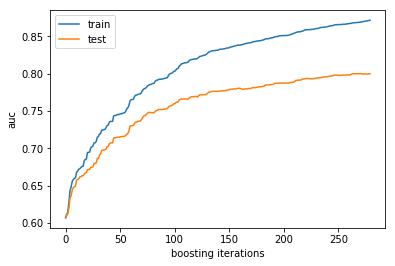

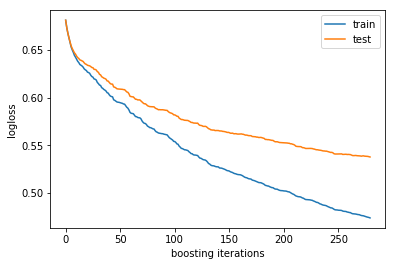

# The amazing all-in-one!

In [1485]:
training_data = data.sample(frac=0.75)
test_data = data.drop(training_data.index,axis=0)

A Jupyter Widget

Generating model. Please be patient... This will take about 30 seconds per fold.
[['19677' '7630']
 ['7734' '19839']]
accuracy: 0.720043731778
precision: 0.722232334632
recall: 0.719508214558
specificity: 0.720584465522
f-score: 0.720867701028


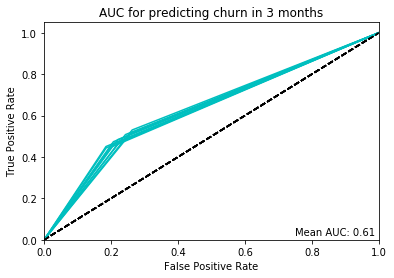

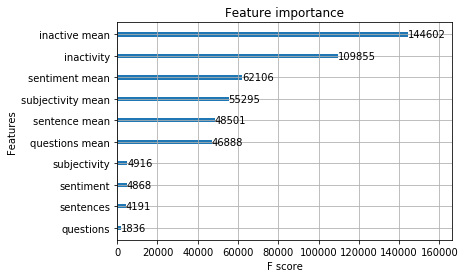

In [1299]:
data=test_data  # when you want to know the optimal parameters, use training_data.
                # When you train the model 'for real', use test_data
k = 10
True_positives=[]
True_negatives=[]
False_positives=[]
False_negatives=[]
feature_importances = defaultdict(int)
feature_names = ["inactivity","questions","sentences","sentiment","subjectivity",
                 "sentence mean","inactive mean","questions mean","sentiment mean","subjectivity mean"]

data_type = "balanced"
X, y = Set_Xy(data,data_type)
ETA = "45 seconds" if data_type == "balanced" else "25 minutes"  
ss = ShuffleSplit(n_splits=k, test_size = .25)
with tqdm(total = k) as pbar:
    print "Generating model. Please be patient... This will take about %s per fold." %ETA
    for train_index,test_index in ss.split(X):
        train_X,test_X,train_y,test_y = Split_data(train_index,test_index)

        # with the information you have now, you can plot the area under the curve
        plot_AUC(train_X,train_y,test_X,test_y)

        dtrain = xgb.DMatrix(train_X.as_matrix(),label=train_y.as_matrix(),feature_names=feature_names)
        dtest = xgb.DMatrix(test_X.as_matrix(),label=test_y.as_matrix(),feature_names=feature_names)
        
        # waarom deze parameters?
        params = {
        "eta": 0.2,
        "max_depth": 8,
        "objective": "binary:logistic",
        "silent": 1,
        "base_score": np.mean(train_y),
        'n_estimators': 400,
        "eval_metric": "auc"}
        model = xgb.train(params, dtrain, 2000, [(dtrain, "train"),(dtest, "validation")], verbose_eval=False)

        # while you're here anyway... keep track of the feature importances
        f_scores = model.get_fscore()
        for fi in f_scores:
            feature_importances[fi] += f_scores[fi]    

        y_pred = model.predict(dtest)
        cm = confusion_matrix(test_y, (y_pred>0.5))

        TP = float(cm[1,1]) # 208 instanties zijn echt 1 en voorspeld 1 (true positive)
        FP = float(cm[0,1]) # 92 instanties zijn echt 0 en voorspeld 1 (false positive)
        FN = float(cm[1,0]) # 2523 instanties zijn echt 1 en voorspeld 0 (false negative)
        TN = float(cm[0,0]) # 147650 instanties zijn echt 0 en voorspeld 0 (true negative)

        True_positives.append(TP)
        True_negatives.append(TN)
        False_positives.append(FP)
        False_negatives.append(FN)
        
        pbar.update(1)

    plt.annotate('Mean AUC: %0.2f' % np.mean(AUROC), xy=(0.99, 0.02), ha = 'right')
    TN=sum(True_negatives)
    TP=sum(True_positives)
    FN=sum(False_negatives)
    FP=sum(False_positives)

    print np.matrix([["%i" %sum(True_negatives),"%i" %sum(False_positives)],["%i" %sum(False_negatives),"%i" %sum(True_positives)]])

    accuracy = (TN+TP)/(TN+TP+FN+FP)
    print "accuracy: "+ str(accuracy)

    precision = TP/(TP+FP)
    print "precision: "+str(precision)

    recall = TP/(TP+FN) #=sensitivity
    print "recall: "+str(recall)

    specificity = TN/(TN+FP)
    print "specificity: "+str(specificity)

    F1 = (2*(precision*recall))/(precision+recall)
    print "f-score: "+str(F1)

    plt.show()
    plot_feature_imporance(feature_importances)
    plt.show()

XGBClassifier(base_score=0.496598639456, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

        params = {
        "eta": 0.2,
        "max_depth": 8,
        "objective": "binary:logistic",
        "silent": 1,
        "base_score": np.mean(train_y),
        'n_estimators': 400,
        "eval_metric": "auc"}
        model = xgb.train(params, dtrain, 2000, [(dtrain, "train"),(dtest, "validation")], verbose_eval=False)

In [851]:
np.matrix([["%i" %sum(True_negatives),"%i" %sum(False_positives)],["%i" %sum(False_negatives),"%i" %sum(True_positives)]])

matrix([['1476793', '345'],
        ['18920', '8672']], dtype='|S7')

### XGB regressor

In [109]:
train_X,test_X,train_y,test_Y = Divide_data("balanced")
model = xgb.XGBRegressor(n_estimators=400, learning_rate=0.05)
model.fit(train_X, train_y, early_stopping_rounds=5,eval_set=[(test_X, test_y)], verbose=True,eval_metric = 'auc')

[0]	validation_0-auc:0.591381
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.592053
[2]	validation_0-auc:0.59315
[3]	validation_0-auc:0.595062
[4]	validation_0-auc:0.593247
[5]	validation_0-auc:0.59341
[6]	validation_0-auc:0.594228
[7]	validation_0-auc:0.595108
[8]	validation_0-auc:0.595134
[9]	validation_0-auc:0.598788
[10]	validation_0-auc:0.599023
[11]	validation_0-auc:0.608838
[12]	validation_0-auc:0.609497
[13]	validation_0-auc:0.609554
[14]	validation_0-auc:0.609696
[15]	validation_0-auc:0.610001
[16]	validation_0-auc:0.611782
[17]	validation_0-auc:0.611858
[18]	validation_0-auc:0.612281
[19]	validation_0-auc:0.612318
[20]	validation_0-auc:0.612811
[21]	validation_0-auc:0.613205
[22]	validation_0-auc:0.613836
[23]	validation_0-auc:0.614938
[24]	validation_0-auc:0.615042
[25]	validation_0-auc:0.614964
[26]	validation_0-auc:0.614994
[27]	validation_0-auc:0.623324
[28]	validation_0-auc:0.623565
[29]	validation_0-auc:0.623315
[30]	validation_0-a

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

build and fit a model

It's smart to set a high value for n_estimators and then use early_stopping_rounds to find the optimal time to stop iterating.

In general, a small learning rate (and large number of estimators) will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle.

#### hoe staat dit tot die andere auc die ik heb berekend?

# Feature importance

In [826]:
# ha ha lekker precies nagemaakt van xgb puh

def plot_feature_imporance(f):
    sorted_f = sorted(f.items(), key=operator.itemgetter(1))
    x_as = range(len(sorted_f))
    values = [f for (_,f) in sorted_f]
    keys = [k for (k,_) in sorted_f]

    plt.close()
    fig,ax=plt.subplots()

    ax.barh(x_as, values ,0.2, align='center')
    ax.yaxis.set_ticks(range(len(keys)))
    ax.yaxis.set_ticklabels(keys)
    ax.set_xlim(0,1.15*max(values))
    ax.set_xlabel("F score")
    ax.set_ylabel("Features")
    ax.set_title("Feature importance")
    ax.grid(True)
    for i,v in enumerate(values):
        plt.text(v, i, str(v), va='center',ha='left')

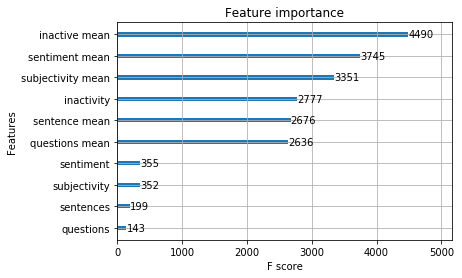

In [827]:
f = model.get_fscore()
plt.close()
plot_feature_imporance(f)
plt.show()

When using early_stopping_rounds, you need to set aside some of your data for checking the number of rounds to use. If you later want to fit a model with all of your data, set n_estimators to whatever value you found to be optimal when run with early stopping.

evaluate the model and make predictions

# AUC

In [1433]:
def plot_AUC(train_X,train_y,test_X,test_y):
    global AUROC
    classifier = clf.best_estimator_
    classifier.fit(train_X,train_y, eval_metric="auc")
    y_score = my_model.predict(test_X)
    
    fpr,tpr,_ = roc_curve(test_y,y_score)
    roc_auc = auc(fpr, tpr)
    AUROC.append(roc_auc)
    
    plt.plot(fpr, tpr, color='c')
    plt.plot([0, 1], [0, 1], color='k', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC for predicting churn in 3 months')

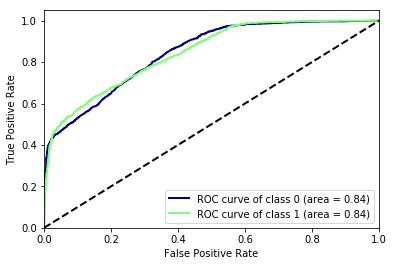

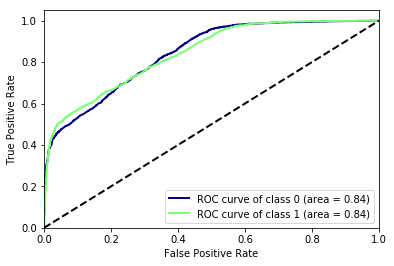

In [1472]:
AUROC = []
X, y = Set_Xy(data,"balanced")
ss = ShuffleSplit(n_splits=2, test_size = .25)
for train_index,test_index in ss.split(X):
    train_X,test_X,train_y,test_y = Split_data(train_index,test_index)
    
    plot_AUC2(train_X,train_y,test_X,test_y)

#plt.annotate('Mean AUC: %0.2f' % np.mean(AUROC), xy=(0.99, 0.02), ha = 'right')
plt.show()

In [1470]:
def plot_AUC2(train_X,train_y,test_X,test_y):
    global AUROC
    classifier = clf.best_estimator_
    classifier.fit(train_X,train_y, eval_metric="auc")
    proba = my_model.predict_proba(test_X)
    
    skplt.metrics.plot_roc([int(y) for y in test_y], list(proba), plot_macro=False, plot_micro=False, title="", cmap="jet")

In [ ]:

proba = my_model.predict_proba(test_X)
skplt.metrics.plot_roc([int(y) for y in test_y], list(proba), plot_macro=False, plot_micro=False, title="", cmap="jet")
plt.show()

Use early stopping to find a good value for n_estimators. Then re-estimate the model with all of your training data, and that value of n_estimators.

# plot predictions vs real values

first generate 'my model'

In [344]:
predictions = model.predict(test_X)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))
# 0,0033 etc voor het voorspellen van 'activity' (tijd sinds laatste post)
# 0.0154 voor zinslengte

AttributeError: 'DataFrame' object has no attribute 'feature_names'

In [95]:
difference = [x-predictions[i] for i,x in enumerate(test_y)]

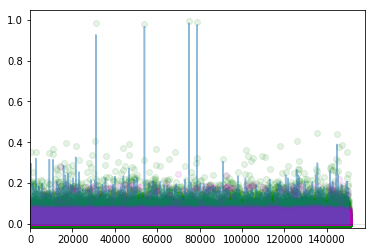

In [98]:
plt.close()
a = [i for i in range(len(test_y))]
plt.plot(a,test_y,'go', alpha = 0.1)
plt.plot(a,predictions,'mo', alpha = 0.1)
plt.plot([np.sqrt(x**2) for x in difference], alpha = 0.5)
plt.axhline(0, linewidth=1, color = 'black', alpha = 0.1)
plt.ylim(-0.02,)
plt.xlim(0,)
plt.show()
# maar heel korte piekjes bij dagen sinds vorige post
# hele lange pieken tot bovenin bij zinslengte

In [42]:
print np.mean(difference)
print np.std(difference)
print np.mean([np.sqrt(x**2) for x in difference]) # mean absolute error

-2.4671557129857766e-05
0.012077691959899708
0.0033124757870574115
